<h1>Exploration of use of pytables and h5py libraries for creating forcing files for MOHID<h1>
    <ol>
        <li>
            <a href="#winds">Winds Structure</a>
        </li>
        <li>
            <a href="#currents">Currents Structure</a>
        </li>
        <li>
            <a href="#createwind">Wind Input file pytables</a>
        </li>
        <li>
            <a href="#createcurrents">Create Current Input file pytables</a>
        </li>
        <li>
            <a href="#windsh5py">Create Wind Input file h5py</a>
        </li>
        <li>
            <a href="#currentsh5py">Create Current Input file h5py</a>
        </li>
        <li>
            <a href="#comparison">Looking at file size and time incentive for different compression levels</a>
        </li>
    </ol>

In [1]:
import numpy as np
from tables import * 
import xarray as xr
import datetime as datetime
from salishsea_tools import viz_tools, utilities
import matplotlib.pyplot as plt
import time
from scipy.interpolate import griddata
import datetime 

<div id='winds'><a name='Winds'></a><h2>Winds Input File Structure</h2></div>

In [9]:
h5wind = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/st_georgia_wind.hdf5')
for group in h5wind.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/wind velocity X (Group) ''
/Results/wind velocity Y (Group) ''


### Read wind grid data metadata

In [13]:
getattr(getattr(h5wind.root.Results, 'wind velocity X'), 'wind velocity X_00001').attrs

/Results/wind velocity X/wind velocity X_00001._v_attrs (AttributeSet), 4 attributes:
   [FillValue := array([0.]),
    Maximum := array([100.]),
    Minimum := array([-100.]),
    Units := b'm/s']

<div id='currents'><a name='Currents'></a><h2>Currents File Structure</h2></div>

In [103]:
h5current = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/St_georgia.hdf5')
for group in h5current.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''


<div id='createwind'><a name='Currents'></a><h2>Create wind input file pytables</h2></div>

In [40]:
# make hdf5 fle for currents
h5file = open_file("temp/winds.hdf5", mode="w", title="Winds Test file")

times = h5file.create_group("/", 'Time', 'Time')
results = h5file.create_group("/", 'Results', 'Results')
wind_u = h5file.create_group(results, 'wind velocity X', 'wind velocity X')
wind_v = h5file.create_group(results, 'wind velocity Y', 'wind velocity Y')

/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'wind velocity X'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'wind velocity Y'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [3]:
GEM = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/hrdps/07apr15-16apr15/GEM.nc').isel(time_counter = slice(23,240))

In [4]:
GEM = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/hrdps/07apr15-16apr15/GEM.nc').isel(time_counter = slice(23,240))

# lat lon data
GEM_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')

# GEM data coordinates
points = np.array([GEM_grid.latitude.values.ravel(), GEM_grid.longitude.values.ravel()-360]).T
# NEMO lat lon grids tuple
xi = (NEMO_grid.latitude.values, NEMO_grid.longitude.values)


# GEM Data

GEM_u = GEM.u_wind.values
GEM_v = GEM.v_wind.values

bar = utilities.statusbar('Loading ...')
u_wind = np.expand_dims(griddata(points, GEM_u[0].ravel(), xi, method='cubic'),0)
v_wind = np.expand_dims(griddata(points, GEM_v[0].ravel(), xi, method='cubic'),0)
for grid in bar(range(1, GEM_u.shape[0])):
    interp_u = griddata(points, GEM_u[grid].ravel(), xi, method='cubic')
    u_wind = np.vstack((u_wind, np.expand_dims(interp_u,0)))
    interp_v = griddata(points, GEM_v[grid].ravel(), xi, method='cubic')
    v_wind = np.vstack((v_wind, np.expand_dims(interp_v,0)))
u_wind1 = u_wind[...,:,1:897:,1:397].astype('float64')
v_wind1 = v_wind[...,:,1:897:,1:397].astype('float64')
u_wind2 = np.transpose(u_wind1, [0,2,1])
v_wind2 = np.transpose(v_wind1, [0,2,1])

Loading ... 100% (216 of 216) |#################################|Time:  0:08:03


In [5]:
u_wind1 = u_wind[...,:,1:897:,1:397].astype('float64')
v_wind1 = v_wind[...,:,1:897:,1:397].astype('float64')

In [6]:
u_wind2 = np.transpose(u_wind1, [0,2,1])
v_wind2 = np.transpose(v_wind1, [0,2,1])

In [ ]:
datelist = GEM.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
datearrays = []
filters =  Filters(complevel=4)
for date in datelist:
    datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
bar = utilities.statusbar('Writing Dates ...')
for i in bar(range(len(datearrays))):
    time_attr = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(6,), chunkshape = (6,), filters = Filters)
bar = utilities.statusbar('Writing U winds ...')
for i in bar(range(u_wind2.shape[0])):
    velocity_attr = 'wind velocity X_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    h5file.create_carray(wind_u, f'{velocity_attr}',obj = u_wind2[i],shape=(396, 896), chunkshape = (396, 896), filters = Filters)
bar = utilities.statusbar('Writing Y winds ...')
for i in bar(range(v_wind2.shape[0])):
    velocity_attr = 'wind velocity Y_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    h5file.create_carray(wind_v, f'{velocity_attr}',obj = v_wind2[i],shape=(396, 896), chunkshape = (396, 896), filters = Filters)
h5file.close()

<div id='createcurrents'><a name='Currents'></a><h2>Create currents input file pytables</h2></div>

Due to the use of dotted notation in pytables, it doesn't like names with spaces in them and spits out pages of warnings each time these are run. I cleared them .

In [2]:
strt = time.time()

In [3]:
# make hdf5 fle for currents
h5file = open_file("temp/currents.hdf5", mode="w", title="Currents Test file")

# make tree structure
times = h5file.create_group("/", 'Time', '')
results = h5file.create_group("/", 'Results', '')
velocity_u = h5file.create_group(results, 'velocity U', '')
velocity_v = h5file.create_group(results, 'velocity V', '')
water_level = h5file.create_group(results, 'water level', '')

/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'velocity U'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'velocity V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'water level'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still wo

In [ ]:
# write in chunks of size 12
sliceend = 35
slicebegin = 23
num_disp = 0
count = 0
while sliceend <= 191:
    U = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/U.nc').isel(time_counter = slice(slicebegin,sliceend))
    V = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/V.nc').isel(time_counter = slice(slicebegin,sliceend))
    T = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/T.nc').isel(time_counter = slice(slicebegin,sliceend))
    datelist = U.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
    # unstagger
    unstaggered_U  = viz_tools.unstagger_xarray(U.vozocrtx, 'x').values[...,:,1:897:,1:397]
    unstaggered_V  = viz_tools.unstagger_xarray(V.vomecrty, 'y').values[...,:,1:897:,1:397]
    unstaggered_T = T.sossheig.values[...,:,1:897:,1:397]
    # rotate
    current_u, current_v = viz_tools.rotate_vel(unstaggered_U, unstaggered_V)
    # clear memory
    unstaggered_U, unstaggered_V = 0,0
    # transpose grid
    current_u = np.transpose(current_u, [0,1,3,2])
    current_v = np.transpose(current_v, [0,1,3,2])
    unstaggered_T = np.transpose(unstaggered_T, [0,2,1])
    # flip by depth dimension
    current_u = np.flip(np.nan_to_num(current_u).astype('float64'), axis = 1)
    current_v = np.flip(np.nan_to_num(current_v).astype('float64'), axis = 1)
    
    unstaggered_T = np.nan_to_num(unstaggered_T).astype('float64')
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
    # write u wind values to hdf5
    for i in range(current_u.shape[0]):
        velocity_attr = 'velocity U_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(velocity_u, f'{velocity_attr}',obj = current_u[i],shape=(40, 396, 896), chunkshape = (40, 396, 896))

    # write v wind values to hdf5
    for i in range(current_v.shape[0]):
        velocity_attr = 'velocity V_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(velocity_v, f'{velocity_attr}',obj = current_v[i],shape=(40, 396, 896), chunkshape = (40, 396, 896))

    # write  water level values to hdf5
    for i in range(unstaggered_T.shape[0]):
        level_attr = 'water level_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(water_level, f'{level_attr}',obj = unstaggered_T[i],shape=(396, 896), chunkshape = (396, 896))
    
    # write time values to hdf5
    for i in range(len(datearrays)):
        time_attr = 'Time_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(6,), chunkshape = (6,))
    num_disp = num_disp + current_u.shape[0]
    slicebegin = sliceend
    sliceend = sliceend + 12
    count = count + 1
    print(count)

In [5]:
h5file.close()

#### This is cool, but I was not able to figure out how to write the metadata for each grid in pytables. Also, the output files are humungous. Like 30 gigs for somethoing that should be 3 gigs. So I will now check out h5py

# Trying with h5py compression

<div id='windsh5py'><a name='Winds'></a><h2>Writing winds file h5py</h2></div>

In [20]:
f.close()

In [21]:
f = h5py.File('winds.hdf5', 'w')

In [22]:
results = f.create_group('Results')

In [23]:
times = f.create_group('Time')
windu = f.create_group('/Results/wind velocity X')
windx = f.create_group('/Results/wind velocity Y')

In [18]:
GEM = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/hrdps/07apr15-16apr15/GEM.nc').isel(time_counter = slice(23,240))

# lat lon data
GEM_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')

# GEM data coordinates
points = np.array([GEM_grid.latitude.values.ravel(), GEM_grid.longitude.values.ravel()-360]).T
# NEMO lat lon grids tuple
xi = (NEMO_grid.latitude.values, NEMO_grid.longitude.values)


# GEM Data

GEM_u = GEM.u_wind.values
GEM_v = GEM.v_wind.values

bar = utilities.statusbar('Loading ...')
u_wind = np.expand_dims(griddata(points, GEM_u[0].ravel(), xi, method='cubic'),0)
v_wind = np.expand_dims(griddata(points, GEM_v[0].ravel(), xi, method='cubic'),0)
for grid in bar(range(1, GEM_u.shape[0])):
    interp_u = griddata(points, GEM_u[grid].ravel(), xi, method='cubic')
    u_wind = np.vstack((u_wind, np.expand_dims(interp_u,0)))
    interp_v = griddata(points, GEM_v[grid].ravel(), xi, method='cubic')
    v_wind = np.vstack((v_wind, np.expand_dims(interp_v,0)))
u_wind1 = u_wind[...,:,1:897:,1:397].astype('float64')
v_wind1 = v_wind[...,:,1:897:,1:397].astype('float64')
u_wind2 = np.transpose(u_wind1, [0,2,1])
v_wind2 = np.transpose(v_wind1, [0,2,1])

Loading ... 100% (216 of 216) |#################################|Time:  0:08:02


In [24]:
datelist = GEM.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
datearrays = []
for date in datelist:
    datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
bar = utilities.statusbar('Writing Dates ...')
for i in bar(range(len(datearrays))):
    time_attr = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    dset = times.create_dataset(time_attr, shape = (6,), data = datearrays[i],chunks=(6,), compression = 'gzip', compression_opts = 1)
    metadata = {'Maximum' : np.array([float(datearrays[i][0])]), 'Minimum' : np.array([-0.]), 'Units' : b'YYYY/MM/DD HH:MM:SS'} # !!!
    dset.attrs.update(metadata)
    #h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(6,), chunkshape = (6,))
bar = utilities.statusbar('Writing X winds ...')
for i in bar(range(u_wind2.shape[0])):
    velocity_attr = 'wind velocity X_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    dset = windu.create_dataset(velocity_attr, shape = (396, 896), data = u_wind2[i],chunks=(396, 896), compression = 'gzip', compression_opts = 1)
    metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([100.]), 'Minimum' : np.array([-100.]), 'Units' : b'm/s'}
    dset.attrs.update(metadata)
    #h5file.create_carray(wind_u, f'{velocity_attr}',obj = u_wind2[i],shape=(396, 896), chunkshape = (396, 896))
bar = utilities.statusbar('Writing Y winds ...')
for i in bar(range(v_wind2.shape[0])):
    velocity_attr = 'wind velocity Y_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    dset =  windx.create_dataset(velocity_attr, shape = (396, 896), data = v_wind2[i],chunks=(396, 896), compression = 'gzip', compression_opts = 1)
    metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([100.]), 'Minimum' : np.array([-100.]), 'Units' : b'm/s'}
    dset.attrs.update(metadata)
    #h5file.create_carray(wind_v, f'{velocity_attr}',obj = v_wind2[i],shape=(396, 896), chunkshape = (396, 896))
f.close()

Writing Dates ... 100% (217 of 217) |###########################|Time:  0:00:00
Writing X winds ... 100% (217 of 217) |#########################|Time:  0:00:17
Writing Y winds ... 100% (217 of 217) |#########################|Time:  0:00:18


<div id='currentsh5py'><a name='Winds'></a><h2>Writing currents file h5py</h2></div>

This has added metadata like in Shihan's files. Done in smaller chunks as a remnant from h5py code boilerplate

In [8]:
compression_level = 1
f = h5py.File('currents.hdf5', 'w')
results = f.create_group('Results')
times = f.create_group('Time')
velocity_u = f.create_group('/Results/velocity U')
velocity_v = f.create_group('/Results/velocity V')
water_level = f.create_group('/Results/water level')

# write in chunks of size 12
sliceend = 35
slicebegin = 23
num_disp = 0
count = 0
while sliceend <= 191: # 191  # execute one loop for comparison
    U = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/U.nc').isel(time_counter = slice(slicebegin,sliceend))
    V = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/V.nc').isel(time_counter = slice(slicebegin,sliceend))
    T = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/T.nc').isel(time_counter = slice(slicebegin,sliceend))
    datelist = U.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
    # unstagger
    unstaggered_U  = viz_tools.unstagger_xarray(U.vozocrtx, 'x').values[...,1:897:,1:397]
    unstaggered_V  = viz_tools.unstagger_xarray(V.vomecrty, 'y').values[...,1:897:,1:397]
    unstaggered_T = T.sossheig.values[...,1:897:,1:397]
    # rotate
    #current_u, current_v = viz_tools.rotate_vel(unstaggered_U, unstaggered_V)
    current_u, current_v = unstaggered_U, unstaggered_V
    # clear memory
    # unstaggered_U, unstaggered_V = 0,0
    # transpose grid
    current_u = np.transpose(current_u, [0,1,3,2])
    current_v = np.transpose(current_v, [0,1,3,2])
    unstaggered_T = np.transpose(unstaggered_T, [0,2,1])
    # flip by depth dimension
    current_u = np.flip(np.nan_to_num(current_u).astype('float64'), axis = 1)
    current_v = np.flip(np.nan_to_num(current_v).astype('float64'), axis = 1)
    unstaggered_T = np.nan_to_num(unstaggered_T).astype('float64')
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
    # write u wind values to hdf5
    bar = utilities.statusbar('Writing U ...')
    for i in bar(range(current_u.shape[0])):
        velocity_attr = 'velocity U_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = velocity_u.create_dataset(velocity_attr, shape = (40, 396, 896), data = current_u[i],chunks=(40, 396, 896), compression = 'gzip', compression_opts = compression_level)
        metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([5.]), 'Minimum' : np.array([-5.]), 'Units' : b'm/s'}
        dset.attrs.update(metadata)

    # write v wind values to hdf5
    bar = utilities.statusbar('Writing V ...')
    for i in bar(range(current_v.shape[0])):
        velocity_attr = 'velocity V_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = velocity_v.create_dataset(velocity_attr, shape = (40, 396, 896), data = current_v[i],chunks=(40, 396, 896), compression = 'gzip', compression_opts = compression_level)
        metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([5.]), 'Minimum' : np.array([-5.]), 'Units' : b'm/s'}
        dset.attrs.update(metadata)

    # write  water level values to hdf5
    bar = utilities.statusbar('Writing Water Levels ...')
    for i in bar(range(unstaggered_T.shape[0])):
        level_attr = 'water level_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = water_level.create_dataset(level_attr, shape = (396, 896), data = unstaggered_T[i],chunks=(396, 896), compression = 'gzip', compression_opts = compression_level)
        metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([5.]), 'Minimum' : np.array([-5.]), 'Units' : b'm'}
        dset.attrs.update(metadata)

    # write time values to hdf5
    bar = utilities.statusbar('Writing Dates ...')
    for i in bar(range(len(datearrays))):
        time_attr = 'Time_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = times.create_dataset(time_attr, shape = (6,), data = datearrays[i],chunks=(6,), compression = 'gzip', compression_opts = compression_level)
        metadata = {'Maximum' : np.array([float(datearrays[i][0])]), 'Minimum' : np.array([-0.]), 'Units' : b'YYYY/MM/DD HH:MM:SS'} # !!!
        dset.attrs.update(metadata)
        
    num_disp = num_disp + current_u.shape[0]
    slicebegin = sliceend
    sliceend = sliceend + 12
    count = count + 1
    print(count)
f.close()

Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


1


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


2


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


3


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


4


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


5


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


6


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


7


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


8


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


9


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


10


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


11


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:07
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


12


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:07
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


13


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:01
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


14


<div id='comparison'><a name='Comparison'></a><h2>Looking at file size and time incentive for different compression levels</h2></div>

### Obtained after wrapping cell above in loop. 12 hour chunks were extrapolated to 7 days worth of data. 

In [65]:
size_mb= []
for i in size_compression:
    size_mb.append(14* float(i.replace(' MB', '')))

In [3]:
a = float(2016)
a

2016.0

Text(0.5, 1.0, 'Time taken (mins) to make hdf one week vs compression factor')

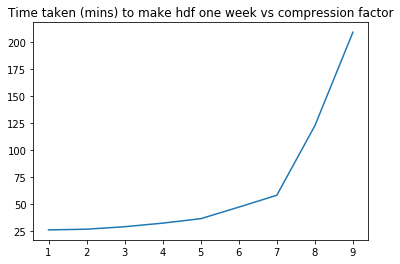

In [70]:
plt.plot(range(1,10), time_compression)
plt.title('Time taken (mins) to make hdf one week vs compression factor')

Text(0.5, 1.0, 'Size of output file (MBs) one week vs compression factor')

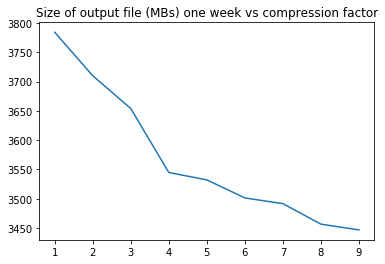

In [71]:
plt.plot(range(1,10), size_mb)
plt.title('Size of output file (MBs) one week vs compression factor')